<a href="https://colab.research.google.com/github/ChabiMax/author_network/blob/main/Code/Question%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><strong><font color="chillipepper">Réseau Wikipédia des auteurs francophones</font></strong></center></h1>
<h5><center><font color="green">Science des réseaux sociaux et économiques <h3><center>


<center>
Maxime Chabriel, Yasmine Houri, Mathis Sansu  

ENSAE 2022
</center>

<h2><center><strong><font color="chillipepper">Analyses descriptives / Traitement de la problématique</font></strong></center></h2>

# Packages

In [1]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import pickle as pkl
from tqdm import tqdm_notebook
!pip install python-louvain


# Données

Import

In [2]:
# Lien du repository GitHub pour récupérer les données
git_url = "https://raw.githubusercontent.com/ChabiMax/author_network/main/"
data = pd.read_pickle(git_url+'/Data/raw_data.pkl')

Visualisation

In [3]:
# Passage du dictionnaire sous forme de dataframe
df = pd.DataFrame(data).T
df.head()

,name,link,date_mort,date_naissance,taille_html_article,network_interauteur,poids_liens_interauteur,genres_mentionnes,type,contemporain,poids_contempo_diff_naissance,poids_contempo_annees_communes,auteurs_du_genre,debut_genre,fin_genre
0,Turold,https://fr.wikipedia.org/wiki/Turold,NaN,NaN,73673,[],[],[],auteur,[],[],[],NaN,NaN,NaN
1,Philippe de Thaon,https://fr.wikipedia.org/wiki/Philippe_de_Thaon,NaN,NaN,68910,[],[],[],auteur,[],[],[],NaN,NaN,NaN
2,Benoît de Sainte-Maure,https://fr.wikipedia.org/wiki/Beno%C3%AEt_de_S...,NaN,NaN,83269,[4],[1],[1627],auteur,[],[],[],NaN,NaN,NaN
3,Jean Bodel,https://fr.wikipedia.org/wiki/Jean_Bodel,1165,NaN,73274,"[10, 22]","[1, 1]","[1663, 1691, 1604]",auteur,[],[],[],NaN,NaN,NaN
4,Wace,https://fr.wikipedia.org/wiki/Wace,1174,1100,99714,[6],[2],"[1591, 1662]",auteur,"[5, 6, 7, 9, 10, 11]","[10, 30, 50, 60, 60, 60]","[52, 44, 24, 14, 14, 14]",NaN,NaN,NaN


# Réseau interauteurs : hyperliens auteurs sur les pages auteurs

Constitution du graph ou les auteurs sont liés par les hyperliens. On décrit blablabla la construciton par scparing


On commence par construire une table d'adjacence :

In [ ]:
id = 0 # Initialisation
id_link = id 
link_table = dict()

for source in tqdm_notebook(df.index) :
  if df.iloc[id]['type'] == "auteur":
    for i in range(len(df.iloc[id]['network_interauteur'])):
      target = df.iloc[id]['network_interauteur'][i]
      link_table[id_link] = {'source' : source, 'target' : target}
      weight = df.iloc[id]['poids_liens_interauteur'][i]
      link_table[id_link]['weight'] = weight
      if target in df.iloc[id]['contemporain'] :
        index_contemp = df.iloc[id]['contemporain'].index(target)
        contemporain = 1
        diff_naissance = df.iloc[id]['poids_contempo_diff_naissance'][index_contemp]
        annees_communes = df.iloc[id]['poids_contempo_annees_communes'][index_contemp]
      else:
        contemporain = 0
        diff_naissance = 0
        annees_communes = 0
      link_table[id_link]['contemporain'] = contemporain
      link_table[id_link]['diff_naissance'] = diff_naissance
      link_table[id_link]['annees_communes'] = annees_communes
      id_link +=1
    id += 1
edge_links = pd.DataFrame(link_table).T
edge_links.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/1786 [00:00<?, ?it/s]

On transforme la table d'adjacence en un objet networkx.


In [ ]:
# Création du graph orienté
GraphAuthorLink = nx.from_pandas_edgelist(edge_links, 'source', 'target', edge_attr = True, create_using=nx.DiGraph())
# On rajoute les attributs
df_node = df[df["type"] == "auteur"]
df_node['Node'] = df_node.index
NodeData = df_node.set_index('Node').to_dict('index').items()
GraphAuthorLink.add_nodes_from(NodeData)
print(nx.info(GraphAuthorLink))

# Réseau interauteurs : partage d'un genre en commun

In [ ]:
df_genre = df[df['type'] == 'genre']

list_link = []
for genre in tqdm_notebook(df_genre.index) :
  auteur_du_genre = df_genre['auteurs_du_genre'][genre]
  if len(auteur_du_genre) > 1 :
    auteur_vu = []
    for auteur in auteur_du_genre :
      for auteur_bis in auteur_du_genre :
        if (auteur != auteur_bis) & (auteur_bis not in auteur_vu) :
          list_link.append([auteur, auteur_bis])
      auteur_vu.append(auteur)

edge_genre = pd.DataFrame(data = list_link)
edge_genre.rename(columns={0: "source", 1: "target"}, inplace = True)
edge_genre['weight'] = 1
edge_genre = edge_genre.groupby(['source','target'])['weight'].agg('count').reset_index()
edge_genre['contemporain'] = 0
edge_genre['diff_naissance'] = 0
edge_genre['annees_communes'] = 0

for i in tqdm_notebook(edge_genre.index) :
  source = edge_genre.iloc[i]['source']
  target = edge_genre.iloc[i]['target']
  if target in df.iloc[source]['contemporain'] :
    index_contemp = df.iloc[source]['contemporain'].index(target)
    contemporain = 1
    diff_naissance = df.iloc[source]['poids_contempo_diff_naissance'][index_contemp]
    annees_communes = df.iloc[source]['poids_contempo_annees_communes'][index_contemp]
  else :
    contemporain = 0
    diff_naissance = 0
    annees_communes = 0
  # print(source, target, contemporain, diff_naissance, annees_communes)
  edge_genre['contemporain'][i] = contemporain
  edge_genre['diff_naissance'][i] = diff_naissance
  edge_genre['annees_communes'][i] = annees_communes



On transforme la table d'adjacence en un objet networkx.


In [ ]:
# Création du graph orienté
GraphGenreLink = nx.from_pandas_edgelist(edge_genre, 'source', 'target', edge_attr = True, create_using=nx.Graph())
# On rajoute les attributs
df_node = df[df["type"] == "auteur"]
df_node['Node'] = df_node.index
NodeData = df_node.set_index('Node').to_dict('index').items()
GraphGenreLink.add_nodes_from(NodeData)
print(nx.info(GraphGenreLink))

# Création des coefficients de pondérations : Contrôler la taille des articles


On visualise la relation entre la taille de l'article d'un auteur et son nombre de connexions. 

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]

# nx.get_node_attributes(GraphAuthorLink, 'taille_html_article')
tailles = nx.get_node_attributes(GraphAuthorLink, 'taille_html_article')
tailles = pd.DataFrame(tailles.items())
degrees = dict()
for (node, val) in GraphAuthorLink.out_degree() :
  degrees[node] = val
degrees = pd.DataFrame(degrees.items())
degree_tailles_df = pd.merge(degrees, tailles, on=0, how='outer')
degree_tailles_df.columns = ['Id', 'degree', 'taille_html_article']
degree_tailles_df['taille_html_article_log'] = np.log(degree_tailles_df['taille_html_article'])
sns.lmplot(y = "degree", x = "taille_html_article_log", data = degree_tailles_df, height = 10, aspect = 15/10)

Un poids de la relation de l'auteur $i$ à l'auteur $j$ par la présence d'un hyperlien dans vers $j$ dans la page de $i$ était déjà fixé en fonction du nombre d'hyperlien vers $j$ que l'on trouvait dans la page de $i$ (notons ces poids $w_{i,j}$). Pour déterminer l'influence de la taille d'un article $i$ ($X_{i}$) sur son nombre de connexion ($Y_{i}$), on décide d'effectuer une régression linéaire :

(1) $Y_{i} = \beta log(X_{i}) + ϵ_{i}$

Notons bien que l'intercept est fixé à 0 (en effet, la relation $f$ entre la taille d'un article x et le nombre d'hypeliens qu'il inclut en son sein $f(x)$ ne fait aucun sens si on n'a pas $f(x) = 0$). Les résidus $ϵ$ de (1) (qu'on maximise à au minimum 0.1 pour éviter de faire disparaître certains liens) sont alors le nombre "réel" de relations (c'est à dire le nombre de relations retranché de l'effet artificiel de la taille de l'article) que l'auteur possède avec d'autres auteurs par les hyperliens présents sur sa page. 

Les poids $w_{i,j}$ sont donc actualisés en des $w'_{i,j}$ de façon à ce que leur somme fasse $ϵ_{i}$.

$w'_{i,j} = w_{i,j}*\frac{max(ϵ_{i}, \: 0.1)}{\sum_{j}w_{i,j}}$


In [ ]:
from tqdm import tqdm_notebook
import statsmodels.formula.api as smf
model = smf.ols("degree ~ taille_html_article_log -1", data = degree_tailles_df)
model = model.fit()
coeff_reg = model.params['taille_html_article_log']
# intercept_reg = model.params['Intercept']

df['poids_liens_interauteur2'] = None
min_true_degrees = 0
for auteur in tqdm_notebook(df['name'][df['type'] == 'auteur']) :
  idx = int(df[df['name'] == auteur].index[0])
  poids = df[df['name'] == auteur]['poids_liens_interauteur']
  poids = list(poids)[0]
  if poids != [] :
    true_degree = list(len(df[df['name'] == auteur]['poids_liens_interauteur']) - coeff_reg*np.log(pd.to_numeric(df[df['name'] == auteur]['taille_html_article'])))[0]
    min_true_degrees = min(min_true_degrees, true_degree)

for auteur in tqdm_notebook(df['name'][df['type'] == 'auteur']) :
  idx = int(df[df['name'] == auteur].index[0])
  poids = df[df['name'] == auteur]['poids_liens_interauteur']
  poids = list(poids)[0]
  if poids != [] :
    true_degree = list(len(df[df['name'] == auteur]['poids_liens_interauteur']) - coeff_reg*np.log(pd.to_numeric(df[df['name'] == auteur]['taille_html_article'])))[0]
    #normalisation_coeff = (true_degree - min_true_degrees + 0.1) / sum(poids)
    normalisation_coeff = max(true_degree, 0.1) / sum(poids)
    poids = [poid * normalisation_coeff for poid in poids]
  else :
    poids = []
  df.at[idx,'poids_liens_interauteur2'] = poids


In [ ]:
for node in GraphAuthorLink.nodes() :
  network = df['network_interauteur'][node]
  for i in range(0, len(network)) :
    indiv = network[i]
    GraphAuthorLink[node][indiv]['weight2'] = df['poids_liens_interauteur2'][node][i]

# Création des coefficients de pondérations : Contrôler l'éclatement des genres

Les genres sont problématiques car leur dénombrement est confronté à de nombreux biais. Notamment, certains genres sont imbriqués les uns dans les autres, ce qui les démultiplie artificiellement. Cependant on ne peut pas non plus les subsumer les uns dans les autres car on est confronté à la création de nouvelles interférences : quels genres subsumer, à quel niveau ? Tous le genre ne sont pas exactement imbriqués les uns dans les autres, et les recoupement se font dans un espace continu, comment prendre cette dimension en compte ? 

Notre projet avait ainsi défini le genre littéraire : un vision de l'écriture ou une manière d'écrire qui peut se définir par une communauté d'auteur partageant cette vision ou empruntant des éléments du genre en question dans leur propre travail. Si un genre peut se définir par une communauté d'auteur, on peut alors dire que la proximité entre deux genres dépend se mesurer par le nombre d'auteurs communs à leurs communautés respectives. Pour un genre $i$, on peut définir un poids $w_{i}$ tel que : 

$w_{i} = \prod_{j} \frac{\#(auteur \: dans \: i \: et \: j)}{\#(auteurs \: dans \: i) \:+\: \#(auteurs \: dans \: j)}$

In [ ]:
df['poids_genre'] = None
df.loc[df['type'] == 'genre', 'poids_genre'] = 1

for genre in tqdm_notebook(np.unique(df[df['type'] == 'genre']['name'])) :
  for genre_bis in np.unique(df[df['type'] == 'genre']['name']) :
    if genre != genre_bis :
      auteurs_du_genre = df.loc[df['name'] == genre, 'auteurs_du_genre']
      auteurs_du_genre_bis = df.loc[df['name'] == genre_bis, 'auteurs_du_genre']
      liste = list(auteurs_du_genre)[0]
      liste_bis = list(auteurs_du_genre_bis)[0]
      if (len(liste) != 0) & (len(liste_bis) != 0) :
        coeff = len(np.unique(liste + liste_bis)) / (len(liste) + len(liste_bis))
        df.loc[df['name'] == genre, 'poids_genre'] = df.loc[df['name'] == genre, 'poids_genre']*(coeff/2)
        

# Statisiques descriptives du réseau x (penser a nommer)

Caractérisitique du graph des auteurs liés par les hyperliens sans isolats. 

In [ ]:
# Removing isolates
GraphAuthorLink_withoutiso = GraphAuthorLink
GraphAuthorLink_withoutiso.remove_nodes_from(list(nx.isolates(GraphAuthorLink_withoutiso)))

print('Dirigé :')
print(type(GraphAuthorLink))
print('\nNombre de noeuds :')
print(GraphAuthorLink_withoutiso.number_of_nodes())
print('\nDensité :')
print(nx.density(GraphAuthorLink_withoutiso))
print('\nRéciprocité globale :')
print(nx.reciprocity(GraphAuthorLink_withoutiso))
print('\nTransitivité :')
print(nx.transitivity(GraphAuthorLink_withoutiso)) # Coeff de cluster global
print('\nAverage clustering :')
print(nx.average_clustering(GraphAuthorLink_withoutiso)) 
print('\nNombre de cliques :')
print(len(list(nx.find_cliques(GraphAuthorLink_withoutiso.to_undirected()))))
print('\nLe graph est connecté :')
print(nx.is_connected(GraphAuthorLink_withoutiso.to_undirected()))
print('\nLe graph est faiblement connecté :')
print(nx.is_weakly_connected(GraphAuthorLink_withoutiso))

# Statisiques descriptives du réseau y (penser a nommer)

Caractérisitique du graph des auteurs liés par les genres. 

In [ ]:
# Removing isolates
GraphGenreLink_withoutiso = GraphGenreLink.copy()
GraphGenreLink_withoutiso.remove_nodes_from(list(nx.isolates(GraphGenreLink_withoutiso)))

print('Dirigé :')
print(type(GraphGenreLink))
print('\nNombre de noeuds :')
print(GraphGenreLink.number_of_nodes())
print('\nNombre de noeuds non isolés :')
print(GraphGenreLink_withoutiso.number_of_nodes())
print('\nDensité :')
print(nx.density(GraphGenreLink_withoutiso))
print('\nRéciprocité globale :')
print(nx.reciprocity(GraphGenreLink_withoutiso))
print('\nTransitivité :')
print(nx.transitivity(GraphGenreLink_withoutiso)) # Coeff de cluster global
print('\nAverage clustering :')
print(nx.average_clustering(GraphGenreLink_withoutiso)) 
print('\nNombre de cliques :')
print(len(list(nx.find_cliques(GraphGenreLink_withoutiso))))
print('\nLe graph est connecté :')
print(nx.is_connected(GraphGenreLink))


# Question 1 : Les structures des réseaux X et Y sont-elles comparables ? 

On établit des métriques qui servent à comparer les deux réseaux. 


On peut d'abord tenter de comparer les noeuds les plus importants de chacun des réseaux.

In [ ]:
from seaborn import matrix
from operator import itemgetter

matrix_data_importance = np.zeros((100,100))

for importance_noeud_genre in tqdm_notebook(range(1, 100)) :

  for importance_noeud_hyperlink in range(1, 100) :

    central_AuthorLink = dict(sorted(nx.degree_centrality(GraphAuthorLink).items(), key = itemgetter(1), reverse = True)[:importance_noeud_hyperlink])
    central_GenreLink = dict(sorted(nx.degree_centrality(GraphGenreLink).items(), key = itemgetter(1), reverse = True)[:importance_noeud_genre])

    common_central_nodes = central_AuthorLink.keys() & central_GenreLink.keys()
    ratio_genre_dans_hyperlink = len(common_central_nodes) / importance_noeud_hyperlink

    matrix_data_importance[importance_noeud_genre][importance_noeud_hyperlink] = ratio_genre_dans_hyperlink


In [ ]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 12]

heatmap_data_importance = pd.DataFrame(matrix_data_importance)
# heatmap_data_importance = heatmap_data_importance.reindex(index = heatmap_data_importance.index[::-1])

sns.heatmap(heatmap_data_importance)
plt.xlabel("Des x noeuds les plus importants dans le graph genre...")
plt.ylabel("% sont dans les y noeuds les plus importants du graph hyperlink.")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)



In [ ]:
y_egal_5 = heatmap_data_importance[5]
y_egal_10 = heatmap_data_importance[10]
y_egal_20 = heatmap_data_importance[20]
y_egal_50 = heatmap_data_importance[50]
y_egal_80 = heatmap_data_importance[80]
x_axis = heatmap_data_importance.columns + 1

plt.plot(x_axis, y_egal_5, label = 'y_egal_5')
plt.plot(x_axis, y_egal_10, label = 'y_egal_10')
plt.plot(x_axis, y_egal_20, label = 'y_egal_20')
plt.plot(x_axis, y_egal_50, label = 'y_egal_50')
plt.plot( x_axis, y_egal_80, label = 'y_egal_80')
plt.ylabel("% des y noeuds les plus importants du graph genre...")
plt.xlabel("...sont dans les x plus importants du graph hyperlink.")
plt.legend()
plt.show()

On compare les nombres de connections de chaque auteur d'un graph à l'autre.

In [ ]:
degrees_auteur = dict(GraphAuthorLink.out_degree(weight  = 'weight2'))
degrees_genre = dict(GraphGenreLink.degree(weight  = 'weight2'))

degree_df = pd.merge(pd.DataFrame(degrees_auteur, index = ['Degree auteur']).T, pd.DataFrame(degrees_genre, index = ['Degree genre']).T, left_index = True, right_index = True)

In [ ]:
plt.scatter(x = 'Degree auteur', y = 'Degree genre', data = degree_df)

# Question 2 : Est-ce que une structure du réseau d'auteur permet d'expliquer l'émergence des genres ? 

# Baseline


On visualise notre variable dépendente : le nombre de nouveaux genres littéraires apparaissant à une date donnée. 

(array([ 3.,  1.,  0.,  6.,  0.,  5.,  0.,  0.,  1.,  4.,  3.,  1.,  0.,
         2.,  4.,  1.,  0.,  8.,  9.,  5.,  2.,  3., 15.,  6.,  5.,  0.,
         1.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  1.,  5.,  7.,  4.,  2.,
        12.]),
 array([1100.0, 1121.825, 1143.65, 1165.475, 1187.3, 1209.125, 1230.95,
        1252.775, 1274.6, 1296.425, 1318.25, 1340.075, 1361.9, 1383.725,
        1405.55, 1427.375, 1449.2, 1471.025, 1492.85, 1514.675, 1536.5,
        1558.325, 1580.15, 1601.975, 1623.8, 1645.625, 1667.4499999999998,
        1689.275, 1711.1, 1732.925, 1754.75, 1776.5749999999998, 1798.4,
        1820.225, 1842.05, 1863.875, 1885.6999999999998, 1907.525, 1929.35,
        1951.175, 1973.0], dtype=object),
 <a list of 40 Patch objects>)

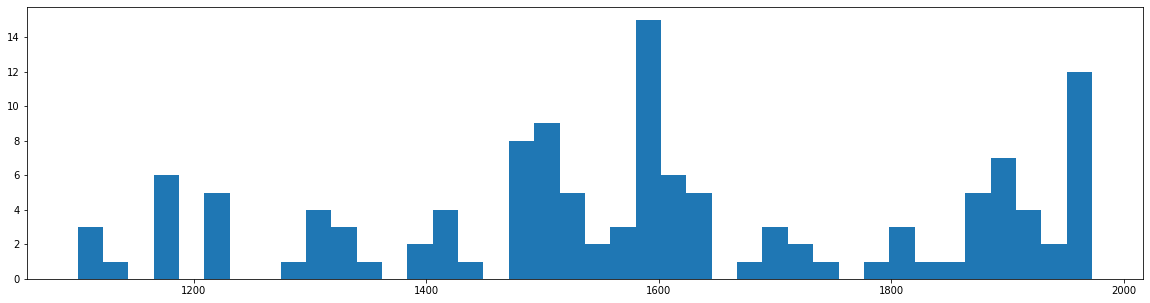

In [604]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

df_genre = df[df['type'] == 'genre']
df_genre = df_genre[df_genre['debut_genre'] != 9999]

plt.hist(df_genre['debut_genre'], bins = 40)

On produit des métriques pour chaque sous-graphe-année pour tester visuellement si il existe une relation potentielle entre la structure du réseau et l'apparition d'un nouveau graph.

In [605]:
from community import community_louvain
from tqdm import tqdm_notebook
import numpy as np

# Year subsets and building metrics
df_auteurs = df[df['type'] == 'auteur']
measure_list = {}
for année in tqdm_notebook(reversed(range(1000, 2025, 5))) :
  selected_nodes = [node for node, value in GraphAuthorLink.nodes(data=True) if (value['date_mort'] >= année) & (value['date_naissance'] <= année)] 
  subgraph = GraphAuthorLink.subgraph(selected_nodes)
  # if len(selected_nodes) > 10 :
  if len(selected_nodes) > 1 :
    try :
      subgraph_undirected = subgraph.to_undirected()
      subgraph_undirected_connected_components = sorted(nx.connected_components(subgraph_undirected), key=len, reverse=True)
      subgraph_undirected_giant = subgraph_undirected.subgraph(subgraph_undirected_connected_components[0])
      community = community_louvain.best_partition(subgraph_undirected, randomize = False)
      community_giant = community_louvain.best_partition(subgraph_undirected_giant, randomize = False)
      measure_list[année] = {'graph_size' : subgraph.number_of_nodes(),
                             'graph_giant_size' : subgraph_undirected_giant.number_of_nodes(),
                             'density_undirected' : nx.density(subgraph_undirected),
                             'density_directed' : nx.density(subgraph), 
                             'density_giant' : nx.density(subgraph_undirected_giant),
                             'average_clustering' : nx.average_clustering(subgraph_undirected_giant),
                             'transitivity' : nx.transitivity(subgraph),
                             'community' : max(list(community)),
                             'community_giant' : max(list(community_giant.values())),
                             'community_giant_variance' : np.var(list(community_giant.values())),
                             'modularity' : community_louvain.modularity(community_giant, subgraph_undirected_giant)}
    except : 
      pass

annee_data = pd.DataFrame(measure_list).T
annee_data['annee'] = annee_data.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

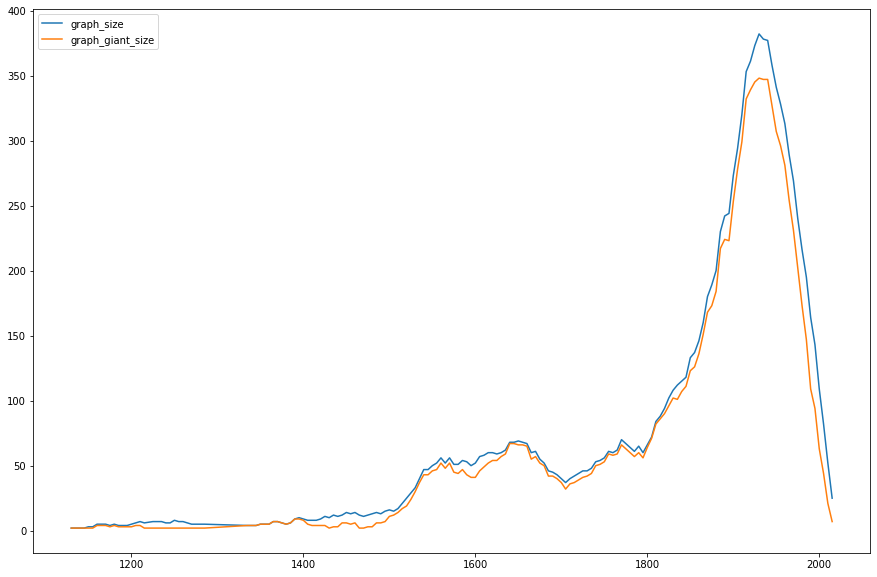

In [606]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['graph_size'], label = 'graph_size')
plt.plot(annee_data['annee'], annee_data['graph_giant_size'], label = 'graph_giant_size')
plt.legend()
plt.show()

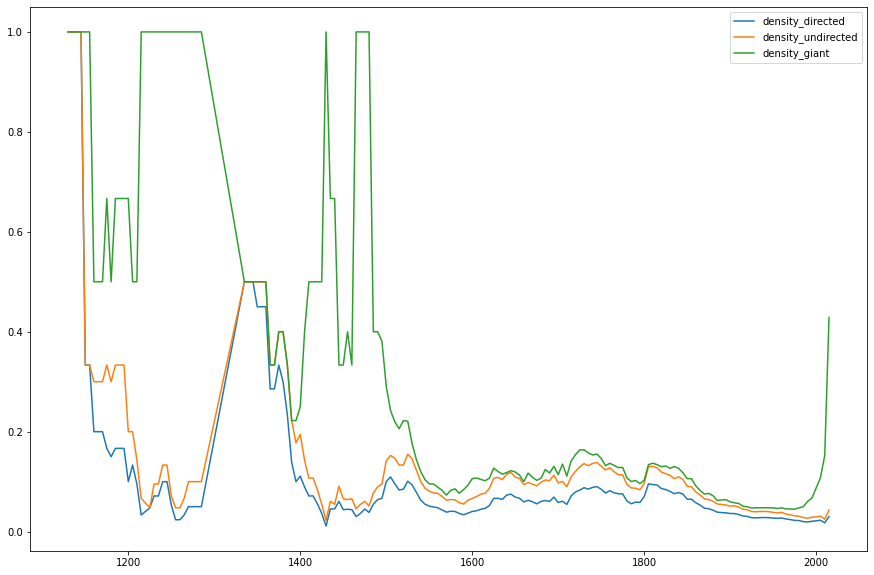

In [607]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['density_directed'], label = 'density_directed')
plt.plot(annee_data['annee'], annee_data['density_undirected'], label = 'density_undirected')
plt.plot(annee_data['annee'], annee_data['density_giant'], label = 'density_giant')
plt.legend()
plt.show()

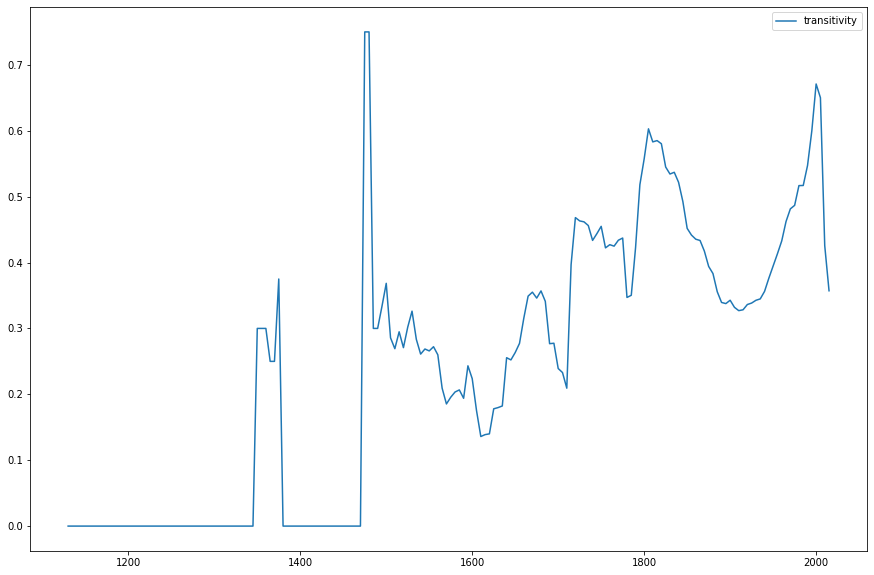

In [608]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['transitivity'], label = 'transitivity')
plt.legend()
plt.show()

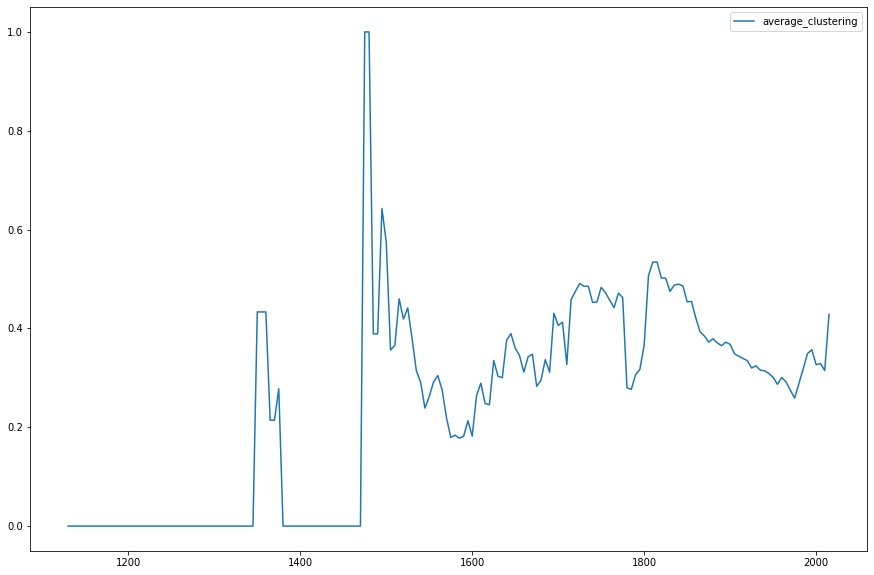

In [609]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['average_clustering'], label = 'average_clustering')
plt.legend()
plt.show()

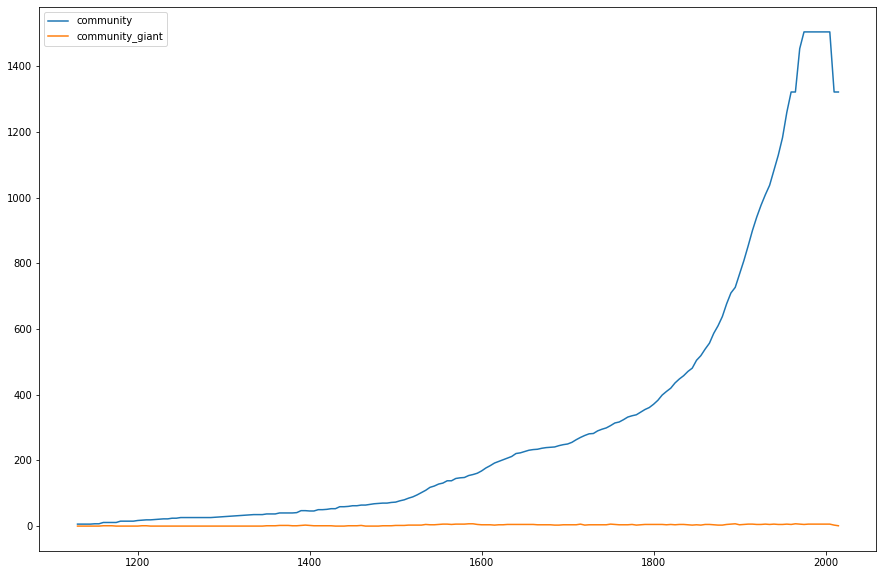

In [610]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['community'], label = 'community')
plt.plot(annee_data['annee'], annee_data['community_giant'], label = 'community_giant')
plt.legend()
plt.show()

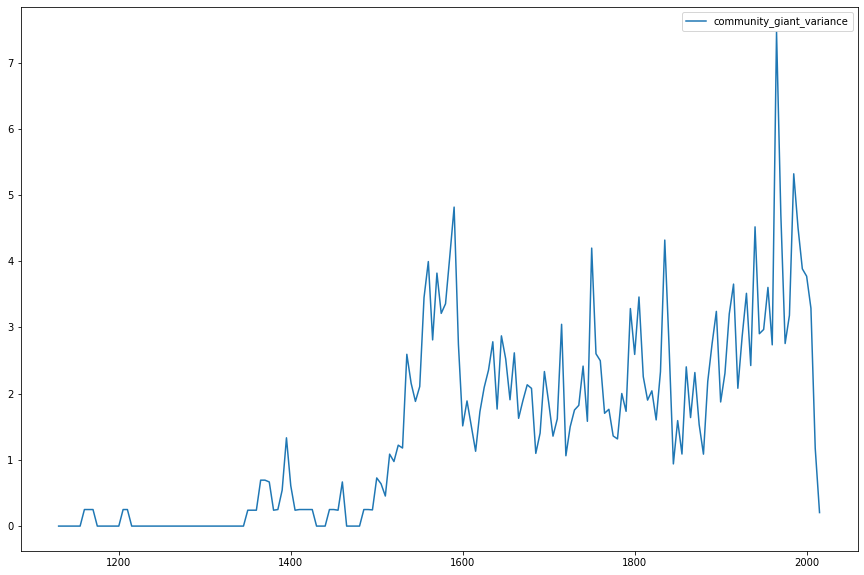

In [611]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['community_giant_variance'], label = 'community_giant_variance')
plt.legend()
plt.show()

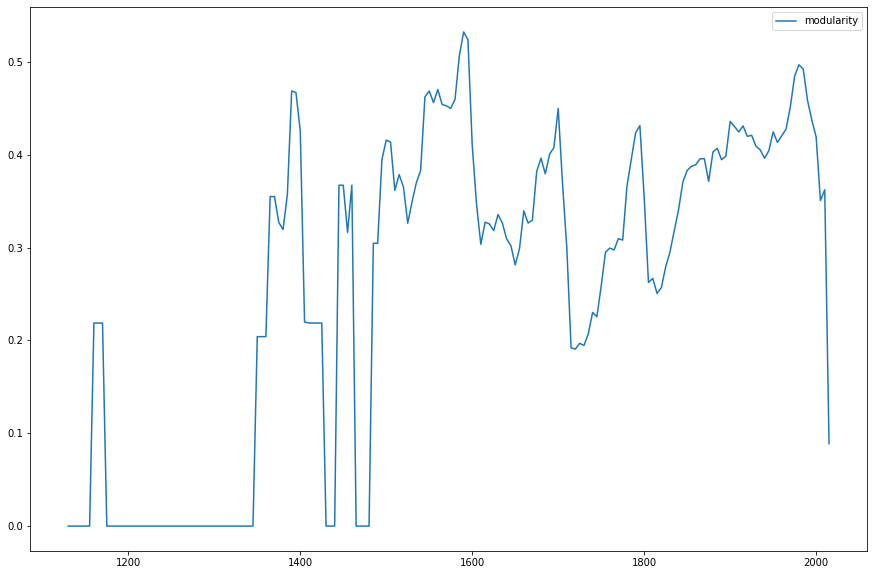

In [612]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['modularity'], label = 'modularity')
plt.legend()
plt.show()

Comparaison

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Year')

Text(0, 0.5, 'average_clustering')

Text(0, 0.5, 'density nb new graph')

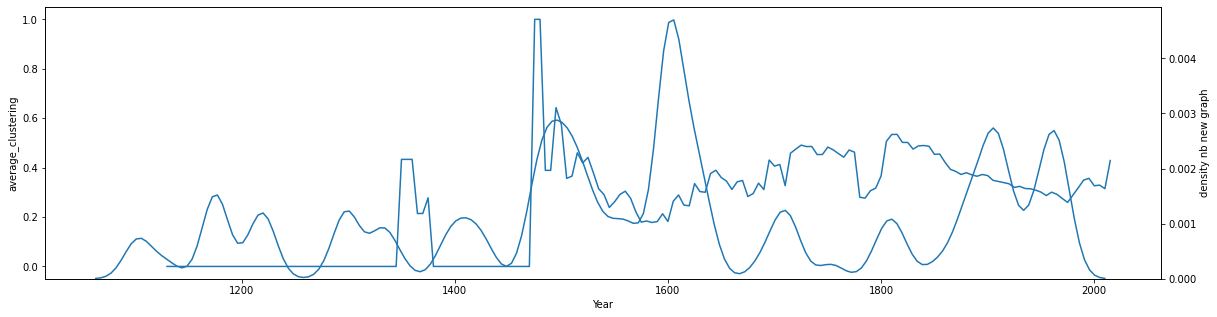

In [613]:
import seaborn as sns
import numpy as np

plt.rcParams['figure.figsize'] = [20, 5]

df_genre = df[df['type'] == 'genre']
df_genre = df_genre[df_genre['debut_genre'] != 9999]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(annee_data['annee'], annee_data['average_clustering'], label = 'average_clustering')
sns.kdeplot(df_genre['debut_genre'], bw=0.05, ax = ax2)

ax1.set_xlabel('Year')
ax1.set_ylabel('average_clustering')
ax2.set_ylabel('density nb new graph')

plt.show()



# Question 2 : Avec les poids

Visualisation de la répartition des tailles d'articles (mise au log).

(array([  1.,   0.,   0.,   0.,   0.,   0.,   4.,  25.,  55., 102., 115.,
        138., 104., 140., 114., 115., 101.,  82.,  75.,  59.,  64.,  54.,
         47.,  25.,  35.,  24.,  17.,  24.,  17.,   7.,   8.,   1.,   7.,
          2.,   5.,  10.,   4.,   1.,   0.,   2.]),
 array([ 9.99729661, 10.09837902, 10.19946143, 10.30054384, 10.40162625,
        10.50270866, 10.60379107, 10.70487348, 10.80595589, 10.9070383 ,
        11.00812071, 11.10920312, 11.21028553, 11.31136794, 11.41245035,
        11.51353276, 11.61461518, 11.71569759, 11.81678   , 11.91786241,
        12.01894482, 12.12002723, 12.22110964, 12.32219205, 12.42327446,
        12.52435687, 12.62543928, 12.72652169, 12.8276041 , 12.92868651,
        13.02976892, 13.13085133, 13.23193374, 13.33301615, 13.43409857,
        13.53518098, 13.63626339, 13.7373458 , 13.83842821, 13.93951062,
        14.04059303]),
 <a list of 40 Patch objects>)

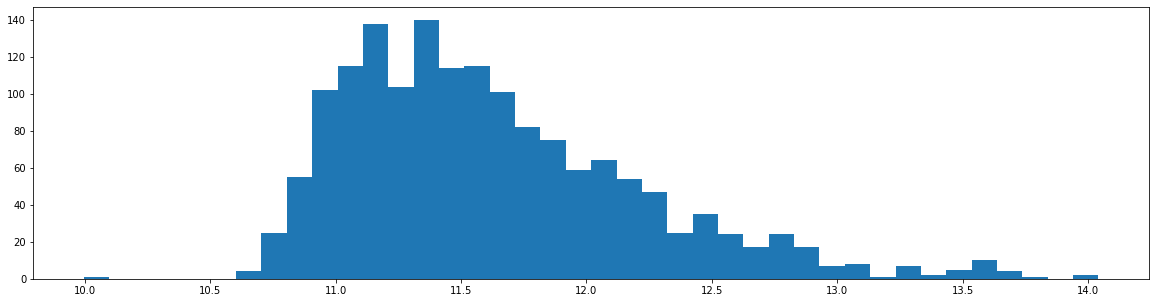

In [614]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.hist(np.log(pd.to_numeric(df_auteurs['taille_html_article'])), bins = 40)

L'année dite de début d'un genre est très sensible aux légères variabilités (théorie des valeurs extrêmes) : un genre mentionné par simple hasard sur la page d'un auteur du sièce précédent fait décaler toute la valeur d'un siècle. Pour désigner l'année de début, on peut se résoudre à faire un moyenne des 2 premières années d'apparition, en excluant la première. 

In [615]:
df['debut_genre_moyenne3'] = None
for genre in df[df['type'] == 'genre'].index :
  subset = df[df['genres_mentionnes'].apply(str).str.contains(str(genre)).tolist()]
  annees = np.unique(subset.date_naissance)
  annees = [x for x in annees if str(x) != 'nan']
  annees = np.sort(annees)[1:3]
  if len(annees) >= 2 :
    df.loc[genre, 'debut_genre_moyenne3'] = np.average(annees)

On visualise la différence entre la densité avec poids et sans poids.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


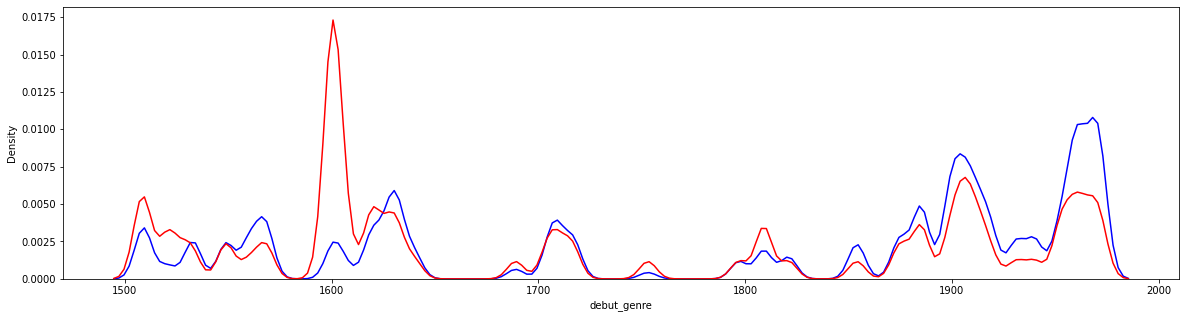

In [616]:
df_genre = df[df['type'] == 'genre']
date_debut = 1500 
date_fin = 2050
BOOL_genre = (df_genre['debut_genre'] > date_debut) & (df_genre['debut_genre'] < date_fin)

sns.kdeplot('debut_genre', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', color = 'blue', data = df_genre[BOOL_genre])
sns.kdeplot('debut_genre', bw=0.025, color = 'red', data = df_genre[BOOL_genre])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


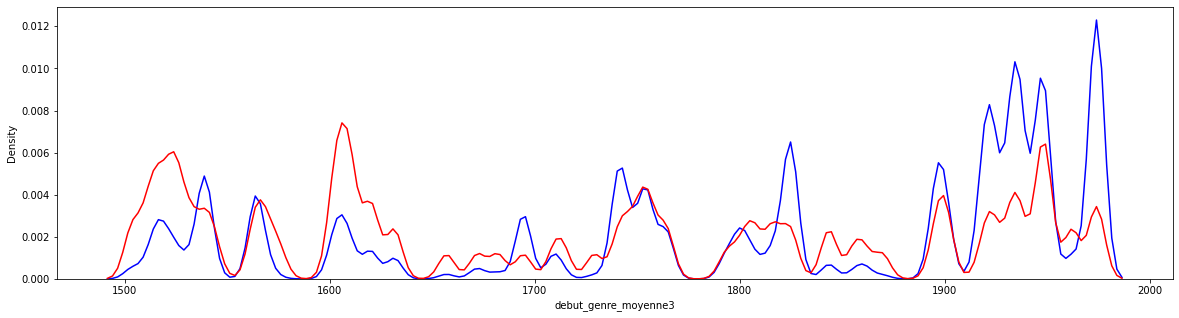

In [617]:
date_debut = 1500 
date_fin = 2050 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)

sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', color = 'blue', data = df_genre[BOOL_genre])
sns.kdeplot('debut_genre_moyenne3', bw=0.025, color = 'red', data = df_genre[BOOL_genre])

On recalcule les métriques des subgraph-année avec les poids actualisés. 

In [ ]:
from tqdm import tqdm_notebook

# Year subsets and building metrics
df_auteurs = df
measure_list = {}
for année in tqdm_notebook(reversed(range(1000, 2025, 5))) :
  selected_nodes = [node for node, value in GraphAuthorLink.nodes(data=True) if (value['date_mort'] >= année) & (value['date_naissance'] <= année)] 
  subgraph = GraphAuthorLink.subgraph(selected_nodes)
  # if len(selected_nodes) > 10 :
  if len(selected_nodes) > 1 :
    try :
      volume_annuel = nx.get_node_attributes(subgraph, 'taille_html_article')
      subgraph_undirected = subgraph.to_undirected()
      subgraph_undirected_connected_components = sorted(nx.connected_components(subgraph_undirected), key=len, reverse=True)
      subgraph_undirected_giant = subgraph_undirected.subgraph(subgraph_undirected_connected_components[0])
      total_articles_len = 0
      community_giant = community_louvain.best_partition(subgraph_undirected_giant, randomize = False)
      for key in subgraph.nodes() :
        total_articles_len += np.log(nx.get_node_attributes(subgraph, 'taille_html_article')[key])
      measure_list[année] = {'average_clustering' : nx.average_clustering(subgraph),
                             'average_clustering_weight' : nx.average_clustering(subgraph, weight = 'weight'),
                             'average_clustering_weight2' : nx.average_clustering(subgraph, weight = 'weight2'),
                             'total_articles_len' : total_articles_len,
                             'modularity' : community_louvain.modularity(community_giant, subgraph_undirected_giant, weight = None),
                             'modularity_weight' : community_louvain.modularity(community_giant, subgraph_undirected_giant, weight = 'weight'),
                             'modularity_weight2' : community_louvain.modularity(community_giant, subgraph_undirected_giant, weight = 'weight2')}
    except : 
      pass

annee_data = pd.DataFrame(measure_list).T
annee_data['annee'] = annee_data.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

Et on visualise avec la variable d'étude pour une approche visuelle des corrélations.

In [ ]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [20, 10]

date_debut = 1500 
date_fin = 2050 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)
BOOL_data = (annee_data['annee'] > date_debut) & (annee_data['annee'] < date_fin)

fig, ax1 = plt.subplots()

sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])
ax1.set_xlabel('Year')
ax1.set_ylabel('density nb new graph')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
plt.plot(annee_data['annee'][BOOL_data], annee_data['average_clustering'][BOOL_data]*0.25, label = 'average_clustering', color = 'g')
plt.plot(annee_data['annee'][BOOL_data], annee_data['average_clustering_weight'][BOOL_data], label = 'average_clustering_weight', color = 'y')
plt.plot(annee_data['annee'][BOOL_data], annee_data['average_clustering_weight2'][BOOL_data], label = 'average_clustering_weight2', color = 'r')

plt.legend()
ax2.set_ylabel('average_clustering')

plt.show()



In [ ]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [20, 10]

date_debut = 1500 
date_fin = 2050 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)
BOOL_data = (annee_data['annee'] > date_debut) & (annee_data['annee'] < date_fin)

fig, ax1 = plt.subplots()

sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])
ax1.set_xlabel('Year')
ax1.set_ylabel('density nb new graph')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
plt.plot(annee_data['annee'][BOOL_data], annee_data['modularity'][BOOL_data], label = 'modularity', color = 'g')
plt.plot(annee_data['annee'][BOOL_data], annee_data['modularity_weight'][BOOL_data], label = 'modularity_weight', color = 'y')
plt.plot(annee_data['annee'][BOOL_data], annee_data['modularity_weight2'][BOOL_data], label = 'modularity_weight2', color = 'r')

plt.legend()
ax2.set_ylabel('modularity')

plt.show()



In [ ]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [20, 10]

date_debut = 1500 
date_fin = 2050 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)
BOOL_data = (annee_data['annee'] > date_debut) & (annee_data['annee'] < date_fin)

fig, ax1 = plt.subplots()

sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])
ax1.set_xlabel('Year')
ax1.set_ylabel('density nb new graph')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
plt.plot(annee_data['annee'][BOOL_data], annee_data['total_articles_len'][BOOL_data], label = 'total_articles_len', color = 'g')

plt.legend()
ax2.set_ylabel('total_articles_len')

plt.show()



In [ ]:
date_debut = 1100 
date_fin = 2100 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)

plot = sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])

annee_mean_liste = list(plot.get_lines()[0].get_data()[1])
annees = list(plot.get_lines()[0].get_data()[0])
annees = [int(annee) for annee in annees]
annee_mean_df = pd.DataFrame({'annee' : annees, 'annee_mean' : annee_mean_liste})
annee_mean_df = pd.merge(pd.DataFrame({'annee' : range(date_debut, date_fin)}), annee_mean_df, on = 'annee', how = 'outer')
annee_mean_df['annee_mean'][-1:] = 0
annee_mean_df['annee_mean_interpolated' ] = annee_mean_df.annee_mean.interpolate(method = 'polynomial', order = 2, limit_direction = 'both')

regression_data = pd.merge(annee_data, annee_mean_df, on = 'annee', how = 'inner')

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import statsmodels.formula.api as smf

def regression(periode, var_dependante, vars_explicatives, vars_controle, data_reg, lag_explicatives = 0, annee_correction = 0) :

  regression_subset = data_reg.copy()

  regression_subset[var_dependante] = 1000*regression_subset[var_dependante]

  regression_subset[var_dependante] = regression_subset[var_dependante].shift(int(annee_correction/5))
  regression_subset[vars_controle] = regression_subset[vars_controle].shift(int(annee_correction/5))

  date_debut = periode[0] 
  date_fin = periode[1] 
  BOOL_regression = (regression_subset['annee'] > date_debut) & (regression_subset['annee'] < date_fin)
  regression_subset = regression_subset[BOOL_regression]

  for var in vars_explicatives :
    regression_subset[var] = regression_subset[var].shift(-int(lag_explicatives/5))

  regression_subset = regression_subset[[var_dependante] + vars_explicatives + vars_controle]
  regression_subset = regression_subset.dropna()

  expression = var_dependante + ' ~ ' + ' + '.join(vars_explicatives) + ' + ' + ' + '.join(vars_controle)
  model = smf.ols(expression, data = regression_subset).fit()
  summary = model.summary()
  params = '\n'.join(['periode' + ' :  ' + str(periode), 
                     'var_dependante' + ' :  ' + str(var_dependante), 
                     'vars_explicatives' + ' :  ' + str(vars_explicatives), 
                     'vars_controle' + ' :  ' + str(vars_controle), 
                     'lag_explicatives' + ' :  ' + str(lag_explicatives),
                     'annee_correction' + ' : ' + str(annee_correction)])
  
  return(summary, params, regression_subset)


In [ ]:
reg, params, reg_data = regression(periode = [1500, 1990],
                          var_dependante = 'annee_mean_interpolated',
                          vars_explicatives = ['modularity_weight2'],
                          vars_controle = ['total_articles_len', 'annee'],
                          lag_explicatives = 50,
                          annee_correction = 30, 
                          data_reg = regression_data)
print(params)
print(reg)
print('\n\n\n888888888888888888888888888888888888888888888888888888888888888888888888888888888888\n\n\n')
